<a href="https://colab.research.google.com/github/purpleiron/MySchoolProjects/blob/main/ResNet50_submission_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **ICT303 - Assignment 1**

**Your name: Muhammad Hafiz Bin Mohd Kassim**

**Student ID: 34576759**

**Email: mdhafiz137@gmail.com**

In this assignment, you will build a deep learning model for identifying $120$ different breeds of dogs. Similar to the previous assignment, you will use real images from the [Kaggle competition](https://www.kaggle.com/c/dog-breed-identification).

In this assignment, your are required to use a ResNet network. You can use ResNet implementation provided in PyTorch. Note however  that there are many versions of ResNet (they differ in terms of number of layers). Your task is to find the best configuration that gives the best performance.

The rule is similar to the previous assignment:

1. Develop a better model to reduce the recognition error.  
2. Submit your results to Kaggle and take a sceenshot of your score. Then insert here the screenshot of your result.

It is important that you start as earlier as possible. Tuning hyper-parameters takes time, and Kaggle limits the number of submissions per day.

The top 3 students in the Kaggle ranking will be invited for a coffee!

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://c.d2l.ai/berkeley-stat-157/homeworks/homework7.pdf

# Step 1: Mount Google Drive and Install Necessary Packages


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install d2l==1.0.0a1.post0
!pip install tqdm


import os
import math
import shutil
import zipfile
import collections
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, datasets, transforms


# Step 2: Copy Zip Files from Google Drive to Colab's Local Filesystem and Unzip

In [2]:
!mkdir -p ./kaggle_dog

data_dir = '/content/drive/My Drive/kaggle_dog'
local_data_dir = './kaggle_dog'

zipfiles = ['train.zip', 'test.zip', 'labels.csv.zip']
for f in zipfiles:
    shutil.copy(os.path.join(data_dir, f), local_data_dir)
    with zipfile.ZipFile(os.path.join(local_data_dir, f), 'r') as z:
        z.extractall(local_data_dir)

# Confirm the files are unzipped properly
!ls ./kaggle_dog

labels.csv  labels.csv.zip  test  test.zip  train  train.zip


# Reorganize dog data

The data in the kaggle_dog folder will be reorganized into a training, validation and testing set.

In [3]:
data_dir = './kaggle_dog'

def mkdir_if_not_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)

!mkdir -p ./kaggle_dog/train_valid_test/test/unknown

def reorg_train_valid(data_dir, train_dir, input_dir, valid_ratio, idx_label):
    min_n_train_per_label = collections.Counter(idx_label.values()).most_common()[:-2:-1][0][1]
    n_valid_per_label = math.floor(min_n_train_per_label * valid_ratio)
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, train_dir)):
        idx = train_file.split('.')[0]
        label = idx_label[idx]
        mkdir_if_not_exist(os.path.join(data_dir, input_dir, 'train_valid', label))
        shutil.copy(os.path.join(data_dir, train_dir, train_file), os.path.join(data_dir, input_dir, 'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            mkdir_if_not_exist(os.path.join(data_dir, input_dir, 'valid', label))
            shutil.copy(os.path.join(data_dir, train_dir, train_file), os.path.join(data_dir, input_dir, 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            mkdir_if_not_exist(os.path.join(data_dir, input_dir, 'train', label))
            shutil.copy(os.path.join(data_dir, train_dir, train_file), os.path.join(data_dir, input_dir, 'train', label))

def reorg_dog_data(data_dir, label_file, train_dir, test_dir, input_dir, valid_ratio):
    # Read the training data labels.
    with open(os.path.join(data_dir, label_file), 'r') as f:
        # Skip the file header line (column name).
        lines = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in lines]
        idx_label = dict(((idx, label) for idx, label in tokens))

    reorg_train_valid(data_dir, train_dir, input_dir, valid_ratio, idx_label)

    # Organize the training set.
    mkdir_if_not_exist(os.path.join(data_dir, input_dir, 'test', 'unknown'))
    for test_file in os.listdir(os.path.join(data_dir, test_dir)):
        shutil.copy(os.path.join(data_dir, test_dir, test_file),
                    os.path.join(data_dir, input_dir, 'test', 'unknown'))


label_file, train_dir, test_dir = 'labels.csv', 'train', 'test'
input_dir, batch_size, valid_ratio = 'train_valid_test', 128, 0.1
reorg_dog_data(data_dir, label_file, train_dir, test_dir, input_dir, valid_ratio)


#Load Dataset and Randomly augment images

After making sure that everything worked and I was able to load the images and then train and test the model, I tried adding random transforms to augment the images in the dataset

In [4]:
train_path = './kaggle_dog/train_valid_test/train'
valid_path = './kaggle_dog/train_valid_test/valid'
test_path = './kaggle_dog/train_valid_test/test'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(20),  # Randomly rotate the image by ±20 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean and std
])

# For validation and testing, usually, only resize and normalization are applied
valid_test_transforms = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(224),  # Crop the center to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=valid_path, transform=valid_test_transforms)
test_dataset = datasets.ImageFolder(root=test_path, transform=valid_test_transforms)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Define ResNet

Here I defined the model. After making sure that I could use ResNet18, I went to use ResNet 34 and then stopped at ResNet50, since it seems like it would take quite a lot of computing power to work on the larger models.

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 120)  #120 in the last layer corresponding to 120 dog breeds
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=25, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize SummaryWriter for TensorBoard
    writer = SummaryWriter()

    # To track the validation loss for early stopping
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training phase
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]', leave=True):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        running_loss = 0.0
        for inputs, labels in tqdm(valid_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]', leave=True):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

        valid_loss = running_loss / len(valid_loader.dataset)

        # Log losses to TensorBoard
        writer.add_scalars('Loss', {'Train': train_loss, 'Validation': valid_loss}, epoch)

        # Early Stopping check
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            patience_counter = 0  # reset counter if validation loss improves
        else:
            patience_counter += 1  # increment counter if no improvement

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        scheduler.step()
        print(f'\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}\n')

    writer.close()  # Close the TensorBoard writer
    print('Finished Training')
    return model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


#Train Model

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
model_trained = train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=25, patience=5)


#Saving model

In [ ]:
# Specify the path where I want to save the model
mkdir_if_not_exist("/content/saved_model/")
model_save_path = '/content/saved_model/resnet50_model.pth'

torch.save(model_trained.state_dict(), model_save_path)


#Testing + CSV generation

In [ ]:
#Model to eval mode:
model.eval()
model.to(device)

dog_breeds = sorted(train_dataset.class_to_idx, key=train_dataset.class_to_idx.get)

predictions = []

for inputs, _ in tqdm(test_loader):
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

    probabilities = probabilities.cpu().numpy()

    predictions.append(probabilities)

predictions = np.vstack(predictions)
submission_df = pd.DataFrame(predictions, columns=dog_breeds)

submission_df.insert(0, 'id', [os.path.basename(path).split('.')[0] for path, _ in test_dataset.imgs])

submission_df.to_csv('resnet50-aug.csv', index=False)


#Reflections

From the first training, I've used a learning rate of 0.001 and 25 epochs to train the model. It was already able to get a pretty good score:
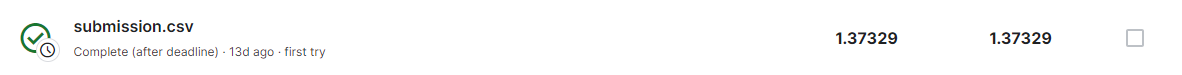

Since it already got a pretty good score, I will try to experiment with different models after I did the image transformations (in the randomly augment Images part of the notebook). After that, the score worsened a little bit:
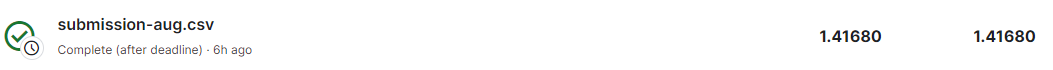

After making sure that everything works fine, I wanted to start experimenting with the different models.

I tried changing the model to ResNet34 and tried training it with the same parameters to see if changing the model would make the score better, and I got a significantly better result:
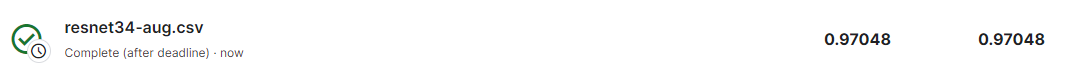

Next, I'm gonna try ResNet50 next and see if that will improve things further.
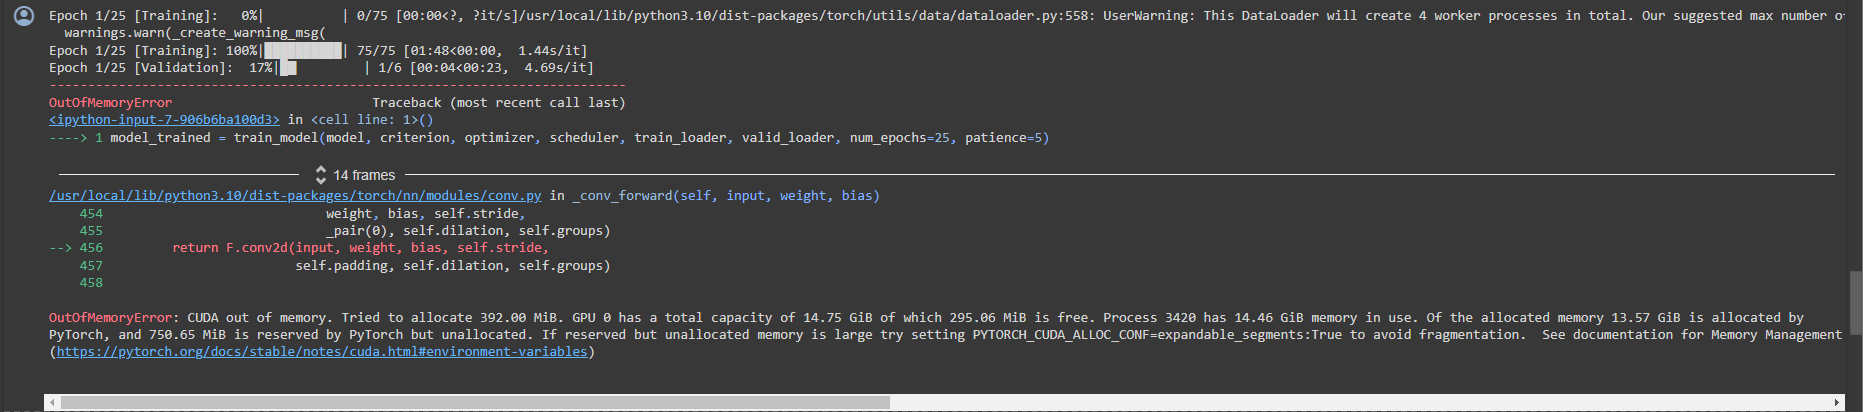


There's a problem. It seems like with the T4 gpu, there's not enough memory for ResNet50. Since I have Colab Pro, I will try using a different GPU.


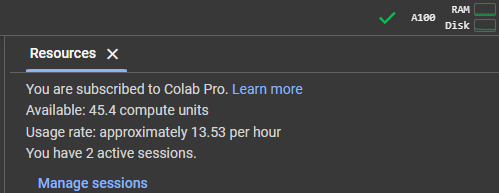


Using the A100 uses quite a bit of compute units so I'm just gonna quickly try once.


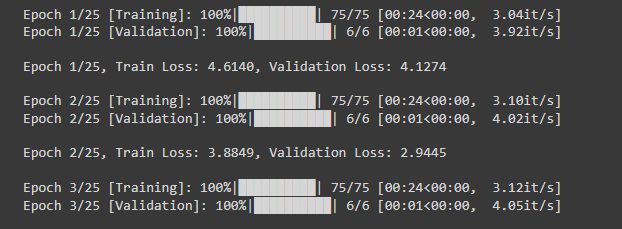


the A100 is pretty fast though, each epoch is 24 seconds


In the end, it's a little better, but not significantly better.
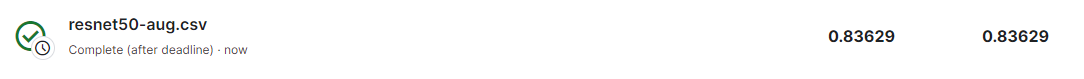




#Conclusion

Changing the models did more to improve the results of the test than changing the hyperparameters like learning rate and number of epochs. From what I experienced, increasing the learning rate usually resulted in the loss being much higher in the end. Increasing the number of epochs did help to reduce the loss, but after 25 epochs, the curve was almost flat and would usually trigger early stopping. In conclusion, I think my original learning rate of 0.001 and 25 epochs was the most optimal.